## Bagging meta-estimator
### 基本描述

在集成算法中，bagging 方法会在原始训练集的随机子集上构建一类黑盒估计器的多个实例，然后把这些估计器的预测结果结合起来形成最终的预测结果。 该方法通过在构建模型的过程中引入随机性，来减少基估计器的方差(例如，决策树)。 在多数情况下，bagging 方法提供了一种非常简单的方式来对单一模型进行改进，而无需修改背后的算法。 因为 bagging 方法可以减小过拟合，所以通常在强分类器和复杂模型上使用时表现的很好（例如，完全决策树，fully developed decision trees），相比之下 boosting 方法则在弱模型上表现更好（例如，浅层决策树，shallow decision trees）。

bagging 方法有很多种，其主要区别在于随机抽取训练子集的方法不同：

 - 如果抽取的数据集的随机子集是样例的随机子集，我们叫做 Pasting 。
 - 如果样例抽取是有放回的，我们称为 Bagging 。
 - 如果抽取的数据集的随机子集是特征的随机子集，我们叫做随机子空间 (Random Subspaces)。
 - 最后，如果基估计器构建在对于样本和特征抽取的子集之上时，我们叫做随机补丁 (Random Patches) 。

在 scikit-learn 中，bagging 方法使用统一的 BaggingClassifier 元估计器（或者 BaggingRegressor ），输入的参数和随机子集抽取策略由用户指定。max_samples 和 max_features 控制着子集的大小（对于样例和特征）， bootstrap 和 bootstrap_features 控制着样例和特征的抽取是有放回还是无放回的。 当使用样本子集时，通过设置 oob_score=True ，可以使用袋外(out-of-bag)样本来评估泛化精度。

### 采样概率
 在Bagging中,一个样本可能被多次采样,也可能一直不被采样,假设一个样本一直不出现在采样集的概率为。$(1-\frac{1}{N}) ^ N$,那么对其求极限可知,原始样本数据集中约有63.2%的样本出现在了,Bagging使用的数据集中,同时在采样中,我们还可以使用袋外样本(out of Bagging)来对我们模型的泛化精度进行评估.
 
### 最终的预测结果
 - 对于分类任务使用简单投票法,即每个分类器一票进行投票(也可以进行概率平均)
 - 对于回归任务,则采用简单平均获取最终结果,即取所有分类器的平均值
 
虽然在Bagging中引入的随机分割增加了偏差,但是因为多个模型的集成平均,同时也使得我们在总体上获取了更好的模型,在本篇文章中,我们称之为Bagging的特性一,在后面我们将会验证这一特性。

## 简单的实用
### 基于KNN的Bagging算法

关于参数和方法要注意的是:

  - 首先控制特征子采样与样本子采样是否采用,采用的话是否要注意控制比例(一般而言,不要采取较小的数值,太小的特征子采样和样本子采样都会造成子学习器的性能太差.).
  - 其次控制Bagging中的随机数参数random_state固定,不然不同实验的结果将不一致,同时要注意的很多时候random_state对于测试误差的影响很大,因此加入你想要在某一个数据集上使用Bagging，那么建议多尝试几个不同的Random_state
  - oob_score = True 对性能有一定的提升(使用袋外样本进行泛化能力的评估,但是很多时候效果并不明显)
  - 其他参数一般默认即可

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# load data
from sklearn import datasets,model_selection
def load_data():
    iris=datasets.load_iris() # scikit-learn 自带的 iris 数据集
    X_train=iris.data
    y_train=iris.target
    return model_selection.train_test_split(X_train, y_train,test_size=0.25,random_state=0,stratify=y_train)

bagging = BaggingClassifier(KNeighborsClassifier(),max_samples=0.1,max_features=0.5,random_state=1,)

X_train,X_test,y_train,y_test=load_data()

bagging.fit(X_train,y_train)
y_pre = bagging.predict(X_test)
print(accuracy_score(y_test,y_pre))

0.9473684210526315


In [6]:
bagging = BaggingClassifier(KNeighborsClassifier(),max_samples=0.1,max_features=0.5,random_state=1,oob_score=True)

X_train,X_test,y_train,y_test=load_data()

bagging.fit(X_train,y_train)
y_pre = bagging.predict(X_test)
print(accuracy_score(y_test,y_pre))
print(bagging.oob_score_)

0.9473684210526315
0.9285714285714286


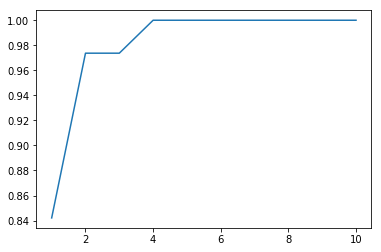

In [31]:
import matplotlib.pyplot as plt
import numpy as np

param_range = range(1,11,1)
sores_list = []
for i in param_range:
    baggingclf = BaggingClassifier(KNeighborsClassifier(),max_samples = i/10,max_features=0.5,random_state=1000,oob_score=True)
    baggingclf.fit(X_train,y_train)
    y_pre = baggingclf.predict(X_test)
    sores_list.append(accuracy_score(y_test,y_pre,normalize=True))

plt.plot(param_range,sores_list) 
plt.show()

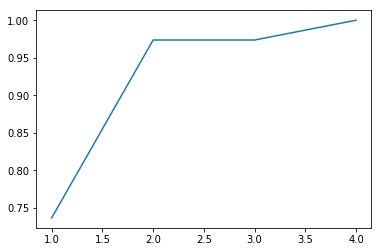

In [32]:
sores_list = []
param_range = range(1,X_train.shape[1]+1)
for i in param_range:
    baggingclf_2 = BaggingClassifier(KNeighborsClassifier(),max_samples = 0.5,max_features=i,random_state=100,oob_score=True)
    baggingclf_2.fit(X_train,y_train)
    y_pre = baggingclf_2.predict(X_test)
    sores_list.append(accuracy_score(y_test,y_pre,normalize=True))

plt.plot(param_range,sores_list)
plt.show()

#### 随机数对训练误差与测试误差的影响

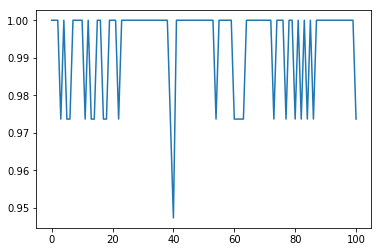

In [34]:
sores_list = []
param_range = range(0,101)
for i in param_range:
    baggingclf_2 = BaggingClassifier(KNeighborsClassifier(),max_samples = 0.8,max_features=0.8,random_state=i)
    baggingclf_2.fit(X_train,y_train)
    y_pre = baggingclf_2.predict(X_test)
    sores_list.append(accuracy_score(y_test,y_pre,normalize=True))

plt.plot(param_range,sores_list)
plt.show()

### 偏差方差分解

之前我们说过:虽然在Bagging中引入的随机分割增加了偏差,但是因为多个模型的集成平均,同时也使得我们在总体上获取了更好的模型.而下面就是对Bagging误差分解后与单个决策树的对比图。Bagging(Tree)相较于Tree增加了偏差,但是降低了方差,最终得到了优于Tree的模型,而同样的Bagging(Tree)_2进一步大幅度增加了偏差,但是同样的方差也大幅度下降,最终得到了效果优于Bagging(Tree)的最终模型。

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)
Bagging(Tree)_2: 0.0195 (error) = 0.0020 (bias^2)  + 0.0075 (var) + 0.0098 (noise)


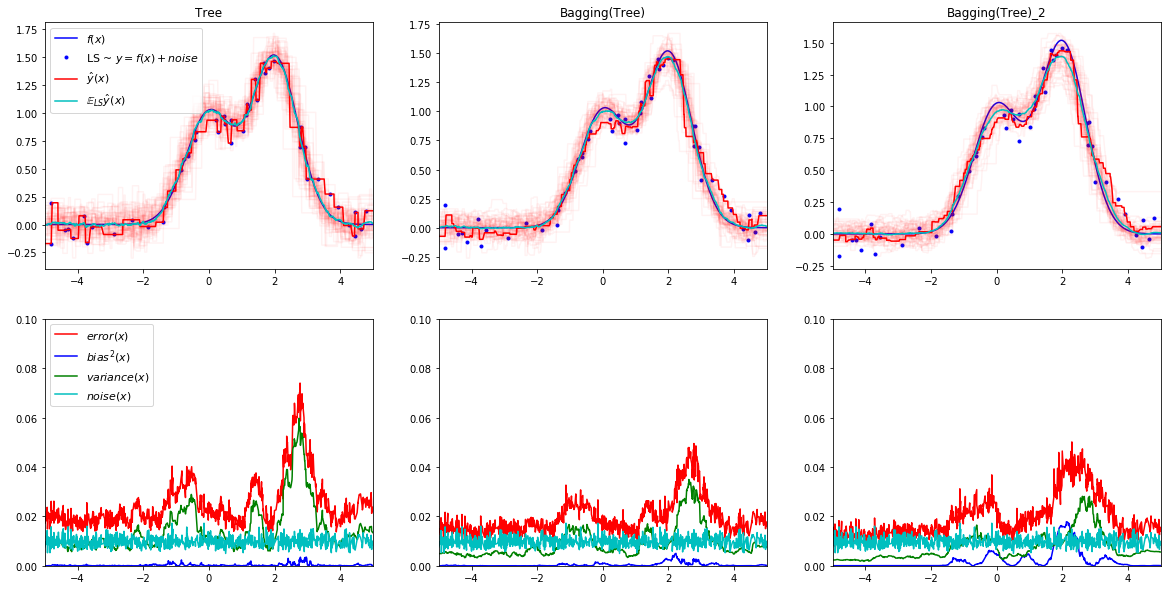

In [53]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
              ("Bagging(Tree)_2",BaggingRegressor(DecisionTreeRegressor(), max_samples=0.5, random_state=100))]

n_estimators = len(estimators)

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == 0:
        plt.legend(loc="upper left", prop={"size": 11})

plt.show()

## 参考
 - [sklearn ApacheCN中文官方文档 : 集成算法](http://sklearn.apachecn.org/cn/0.19.0/modules/ensemble.html)
 - [sklearn官方文档 : Single estimator versus bagging: bias-variance decomposition](http://sklearn.apachecn.org/cn/0.19.0/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py)
 - 《机器学习》 周志华编著